<a href="https://colab.research.google.com/github/PatrykGluszekDS/TensorFlow-Projects-Showcase/blob/main/NN-Classification/Credit_Card_Fraud_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import pandas as pd
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns, datetime
import joblib, os, hashlib, json, tqdm, warnings, random

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, RocCurveDisplay, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

warnings.filterwarnings("ignore")
RANDOM = 42

# 🏁 1 · Project Bootstrap & Data Import

In this section:

1. Downloading the European credit-card fraud dataset (284 k samples, <1 % fraud)  
2. Loading into a Pandas dataframe and running a quick sanity check


In [2]:
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

df = pd.read_csv(path + "/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print(f"Shape: {df.shape}")
print(df['Class'].value_counts(normalize=True).mul(100).round(4))

Shape: (284807, 31)
Class
0    99.8273
1     0.1727
Name: proportion, dtype: float64


🔍 **Observation:** Only **0.172 %** of transactions are fraudulent—severe class imbalance.

# 🔎 2 · Exploratory Data Analysis

Goals for this section:

* Visualise target-class imbalance  
* Inspect the € `Amount` distribution (log-scale)  
* Explore feature correlations (`V1–V28`)  
* Check fraud-rate over time

In [4]:
df['Class'].value_counts()

,count
Class,
0,284315
1,492


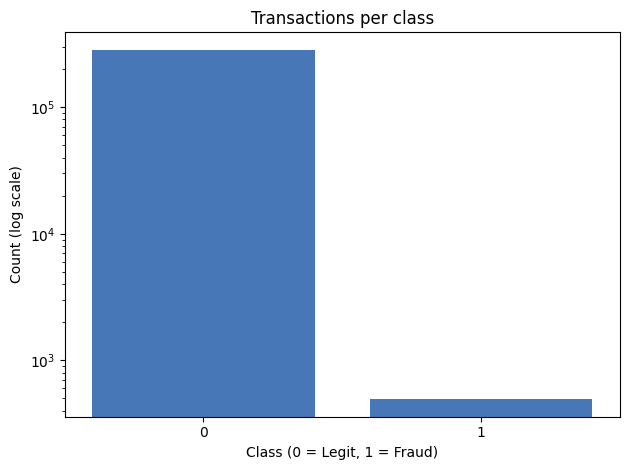

In [5]:
# Class imbalance bar plot
class_counts = df['Class'].value_counts().sort_index()

plt.figure()
sns.barplot(x=class_counts.index.astype(str),
            y=class_counts.values, color='#3475ca')
plt.yscale('log')
plt.xlabel('Class (0 = Legit, 1 = Fraud)')
plt.ylabel('Count (log scale)')
plt.title('Transactions per class')
plt.tight_layout()
plt.show()

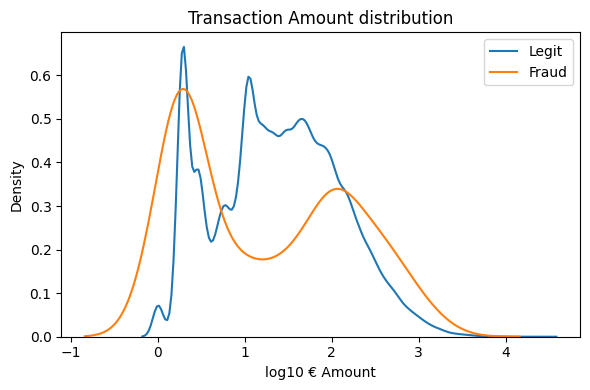

In [6]:
# Amount distribution (log10 €) by class
plt.figure(figsize=(6, 4))
for cls, label in zip([0, 1], ['Legit', 'Fraud']):
    subset = df[df['Class'] == cls]['Amount']
    sns.kdeplot(np.log10(subset + 1), label=label)
plt.xlabel('log10 € Amount')
plt.title('Transaction Amount distribution')
plt.legend()
plt.tight_layout()
plt.show()


Legit curve peaks ≈ 10¹ € (≈ €10) then trails off

Fraud has two humps — one near legit’s peak and another around log₁₀≈2 € (≈ €100).

***Fraudsters slightly prefer mid-range amounts but overlap is large → Amount alone can’t separate classes; still worth keeping after standardisation.***

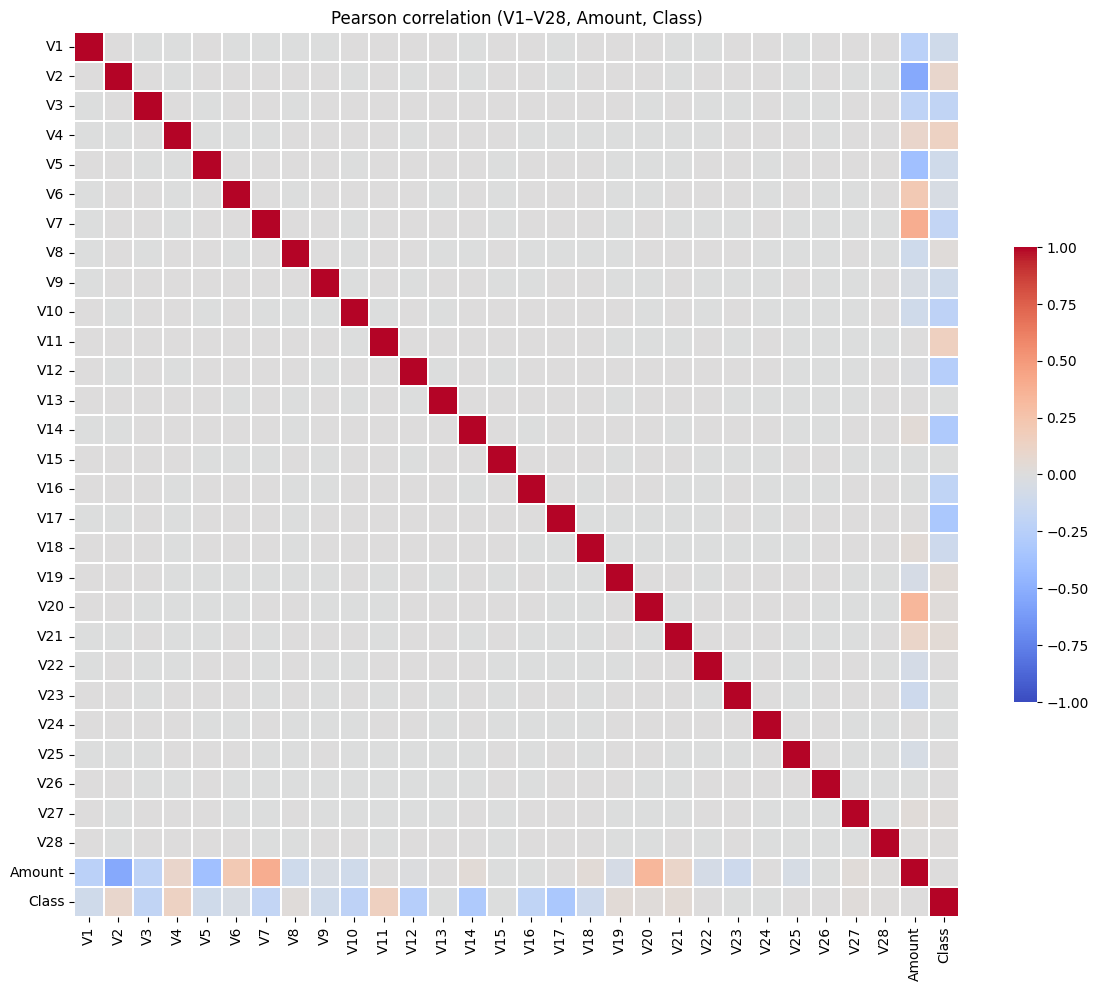

In [7]:
# Correlation heat-map
plt.figure(figsize=(12, 10))
corr = df.drop(columns=['Time']).corr()
sns.heatmap(corr, cmap='coolwarm', vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .5})
plt.title('Pearson correlation (V1–V28, Amount, Class)')
plt.tight_layout()
plt.show()


Off-diagonal cells for V1-V28 are ~0 (grey). That’s expected—these are PCA components designed to be linearly uncorrelated. Amount shows weak pos/neg links with a few components (e.g. V7, V20).

***Tree models & neural nets can still exploit higher-order interactions, but classic linear models will gain little from multicollinearity tricks. No need for further decorrelation.***

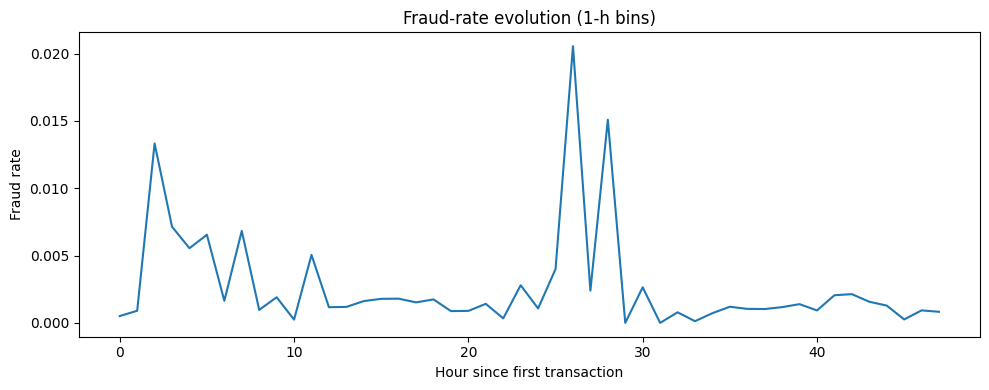

In [8]:
# Fraud rate by 1-hour bins
df['Hour'] = (df['Time'] // 3600).astype(int)
hourly = df.groupby('Hour')['Class'].agg(['sum', 'count'])
hourly['fraud_rate'] = hourly['sum'] / hourly['count']

plt.figure(figsize=(10, 4))
plt.plot(hourly.index, hourly['fraud_rate'])
plt.xlabel('Hour since first transaction')
plt.ylabel('Fraud rate')
plt.title('Fraud-rate evolution (1-h bins)')
plt.tight_layout()
plt.show()

Sharp spikes (e.g., hour ≈ 25 hits ~2 % fraud)

***Plot suggests that frauds could occur in bursts and could be coordinated attacks.***

# 🛠️ 3 · Data Pre-processing & Split

In [9]:
# config
TEST_SIZE  = 0.15
VAL_SIZE   = 0.15   # of original data (not of remaining)
RANDOM_SEED = 42
OUT_DIR = '/content/data/processed'
os.makedirs(OUT_DIR, exist_ok=True)

In [10]:
#  Drop 'Time' & separate features/target ---
X = df.drop(columns=['Time', 'Class'])
y = df['Class'].values

In [11]:
# Min-Max scale 'Amount'
scaler = MinMaxScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])

In [12]:
# Persist scaler for inference
joblib.dump(scaler, os.path.join(OUT_DIR, 'amount_minmax.pkl'))

['/content/data/processed/amount_minmax.pkl']

In [13]:
# Train / temp-test split (stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=TEST_SIZE+VAL_SIZE, stratify=y, random_state=RANDOM_SEED)

# Split temp into val & test so overall ratios are 0.15 each
relative_val_size = VAL_SIZE / (TEST_SIZE + VAL_SIZE)  # -> 0.5
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1-relative_val_size, stratify=y_temp, random_state=RANDOM_SEED)

print({k:v.shape for k,v in
       [('train',X_train),('val',X_val),('test',X_test)]})

{'train': (199364, 30), 'val': (42721, 30), 'test': (42722, 30)}


In [14]:
# Save NumPy arrays (compact & fast)
np.save(os.path.join(OUT_DIR,'X_train.npy'), X_train.values)
np.save(os.path.join(OUT_DIR,'y_train.npy'), y_train)
np.save(os.path.join(OUT_DIR,'X_val.npy'),   X_val.values)
np.save(os.path.join(OUT_DIR,'y_val.npy'),   y_val)
np.save(os.path.join(OUT_DIR,'X_test.npy'),  X_test.values)
np.save(os.path.join(OUT_DIR,'y_test.npy'),  y_test)

✅ **Artifacts saved** to `data/processed/`  
We can now train models without data-leakage worries. Next: handle the extreme imbalance

# ⚖️ 4 · Imbalance Handling & Baseline Metrics
I try three techniques (class-weights, SMOTE, RandomUnderSampler) and
benchmark a fast **Logistic Regression** on each to see which gives the best
AUROC/AUPRC on the untouched validation set.

In [15]:
X_train = np.load('/content/data/processed/X_train.npy')
y_train = np.load('/content/data/processed/y_train.npy')
X_val   = np.load('/content/data/processed/X_val.npy')
y_val   = np.load('/content/data/processed/y_val.npy')

In [16]:
def eval_model(model, name):
    proba = model.predict_proba(X_val)[:,1]
    auroc = roc_auc_score(y_val, proba)
    auprc = average_precision_score(y_val, proba)
    print(f"{name:18}  AUROC {auroc:.4f}  AUPRC {auprc:.4f}")
    return proba, auroc, auprc

In [17]:
# Baseline

base_lr = LogisticRegression(max_iter=1000, n_jobs=-1, class_weight=None)
base_lr.fit(X_train, y_train)
p0, auc0, pr0 = eval_model(base_lr, "None / raw")

None / raw          AUROC 0.9545  AUPRC 0.6733


In [18]:
# Class-weights

weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw = {0: weights[0], 1: weights[1]}
cw_lr = LogisticRegression(max_iter=1000, n_jobs=-1, class_weight=cw)
cw_lr.fit(X_train, y_train)
p1, auc1, pr1 = eval_model(cw_lr, "Class-Weights")

Class-Weights       AUROC 0.9677  AUPRC 0.6274


In [19]:
# SMOTE Oversampling

smote = SMOTE(sampling_strategy=0.1, random_state=42)      # fraud:legit ≈1:10
X_sm, y_sm = smote.fit_resample(X_train, y_train)
sm_lr = LogisticRegression(max_iter=1000, n_jobs=-1)
sm_lr.fit(X_sm, y_sm)
p2, auc2, pr2 = eval_model(sm_lr, "SMOTE 1:10")

SMOTE 1:10          AUROC 0.9691  AUPRC 0.6643


In [20]:
# RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
X_ru, y_ru = rus.fit_resample(X_train, y_train)
ru_lr = LogisticRegression(max_iter=1000, n_jobs=-1)
ru_lr.fit(X_ru, y_ru)
p3, auc3, pr3 = eval_model(ru_lr, "UnderSample 1:10")

UnderSample 1:10    AUROC 0.9692  AUPRC 0.6445


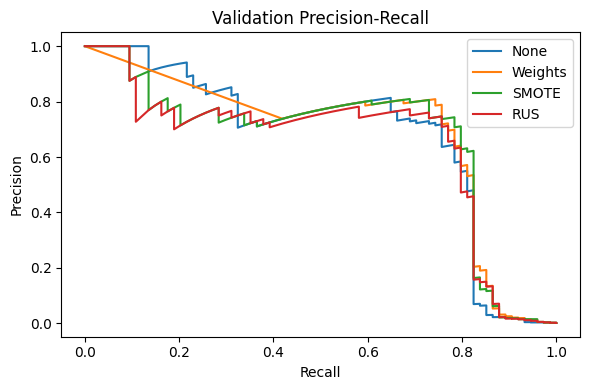

In [21]:
curves = [("None",p0), ("Weights",p1), ("SMOTE",p2), ("RUS",p3)]
plt.figure(figsize=(6,4))
for label, proba in curves:
    pr, rec, _ = precision_recall_curve(y_val, proba)
    plt.plot(rec, pr, label=label)
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Validation Precision-Recall')
plt.legend(); plt.tight_layout(); plt.show()

# 👑 5 · Classic-Model Baselines

Training Logistic Regression, Random Forest, and XGBoost on the
**SMOTE 1 : 10** resampled data, then comparing AUROC & AUPRC on the untouched
validation set.


In [32]:
X_train = np.load('/content/data/processed/X_train.npy')
y_train = np.load('/content/data/processed/y_train.npy')
X_val   = np.load('/content/data/processed/X_val.npy')
y_val   = np.load('/content/data/processed/y_val.npy')

In [33]:
# Apply SMOTE 1:10
smote = SMOTE(sampling_strategy=0.1, random_state=RANDOM)
Xs, ys = smote.fit_resample(X_train, y_train)
print(f"After SMOTE: legit={sum(ys==0)}, fraud={sum(ys==1)}  ratio {sum(ys==0)/sum(ys==1):.1f}:1")

After SMOTE: legit=199020, fraud=19902  ratio 10.0:1


In [34]:
# The same as before
def run_and_eval(model, name):
    model.fit(Xs, ys)
    proba = model.predict_proba(X_val)[:,1]
    auroc = roc_auc_score(y_val, proba)
    auprc = average_precision_score(y_val, proba)
    print(f"{name:14}  AUROC {auroc:.4f}  AUPRC {auprc:.4f}")
    return proba

In [35]:
# Logistic Regression

logreg = LogisticRegression(max_iter=2000, solver="lbfgs", n_jobs=-1)
p_log = run_and_eval(logreg, "LogReg")
joblib.dump(logreg, '/content/models/logreg.pkl');

LogReg          AUROC 0.9691  AUPRC 0.6643


In [39]:
# Random Forest

rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=12,
        n_jobs=-1,
        min_samples_leaf=2,
        random_state=RANDOM, verbose=100)
p_rf = run_and_eval(rf, "RandomForest")
joblib.dump(rf, '/content/models/random_forest.pkl');

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
building tree 1 of 200
building tree 2 of 200
building tree 3 of 200[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s

building tree 4 of 200[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.5s

building tree 5 of 200[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.5s

building tree 6 of 200
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.8s
building tree 7 of 200
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.9s
building tree 8 of 200
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    7.9s
building tree 9 of 200[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    9.7s

building tree 10 of 200[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.1s

building tree 11 of 200[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.0s

building tree 12 of 200
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.2s
building tree 13 of 

In [45]:
# XGBoost

xgb = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        eta=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='binary:logistic',
        eval_metric='aucpr',
        tree_method='hist',
        random_state=RANDOM,
        n_jobs=-1)

xgb.fit(Xs, ys,
        eval_set=[(X_val, y_val)],
        verbose=200)
p_xgb = run_and_eval(xgb, "XGBoost")
joblib.dump(xgb, '/content/models/xgboost.pkl');


[0]	validation_0-aucpr:0.54868
[200]	validation_0-aucpr:0.82007
[299]	validation_0-aucpr:0.82790
XGBoost         AUROC 0.9850  AUPRC 0.8281


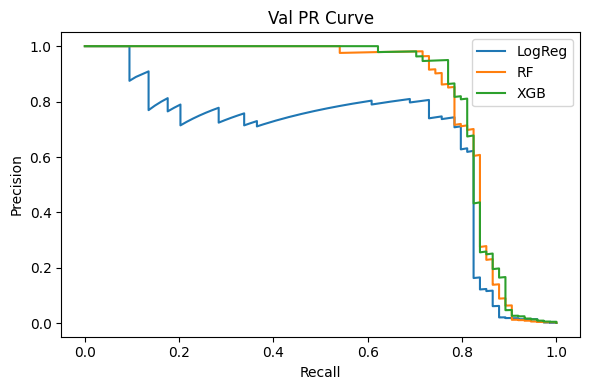

In [46]:
curves = [("LogReg",p_log), ("RF",p_rf), ("XGB",p_xgb)]
plt.figure(figsize=(6,4))
for label,p in curves:
    pr, rec, _ = precision_recall_curve(y_val, p)
    plt.plot(rec, pr, label=label)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Val PR Curve')
plt.legend(); plt.tight_layout(); plt.show()

# 🤖 6 · Neural-Network v1  ‒  Dense Classifier

*Objective:* build a simple feed-forward net that beats XGBoost baseline  
(AUPRC = 0.828) on the validation set.

In [50]:
SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# load splits
X_train = np.load('/content/data/processed/X_train.npy')
y_train = np.load('/content/data/processed/y_train.npy')
X_val   = np.load('/content/data/processed/X_val.npy')
y_val   = np.load('/content/data/processed/y_val.npy')

# SMOTE again (same 1:10 ratio)
sm = SMOTE(sampling_strategy=0.1, random_state=SEED)
Xs, ys = sm.fit_resample(X_train, y_train)
print("Train shape after SMOTE:", Xs.shape, "  Fraud ratio:", ys.mean().round(4))

Train shape after SMOTE: (218922, 30)   Fraud ratio: 0.0909


In [51]:
def make_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512), layers.BatchNormalization(), layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(256), layers.BatchNormalization(), layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(128), layers.BatchNormalization(), layers.Activation('relu'),
        layers.Dropout(0.2),

        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auroc'),
                 tf.keras.metrics.AUC(name='auprc', curve='PR')]
    )
    return model

In [54]:
model = make_model(Xs.shape[1])
es = callbacks.EarlyStopping(monitor='val_auprc', mode='max',
                             patience=7, restore_best_weights=True)
logdir = "/content/logs/nn_v1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = callbacks.TensorBoard(logdir, histogram_freq=1, write_graph=False)

history = model.fit(
    Xs, ys,
    epochs=50,
    batch_size=1024,
    validation_data=(X_val, y_val),
    callbacks=[es, tb],
    verbose=2
)

Epoch 1/50
214/214 - 20s - 93ms/step - auprc: 0.9468 - auroc: 0.9868 - loss: 0.0734 - val_auprc: 0.6578 - val_auroc: 0.9592 - val_loss: 0.0160
Epoch 2/50
214/214 - 2s - 8ms/step - auprc: 0.9898 - auroc: 0.9985 - loss: 0.0250 - val_auprc: 0.6580 - val_auroc: 0.9419 - val_loss: 0.0082
Epoch 3/50
214/214 - 2s - 11ms/step - auprc: 0.9946 - auroc: 0.9995 - loss: 0.0164 - val_auprc: 0.6602 - val_auroc: 0.9432 - val_loss: 0.0069
Epoch 4/50
214/214 - 2s - 7ms/step - auprc: 0.9964 - auroc: 0.9997 - loss: 0.0119 - val_auprc: 0.6594 - val_auroc: 0.9237 - val_loss: 0.0063
Epoch 5/50
214/214 - 3s - 13ms/step - auprc: 0.9976 - auroc: 0.9998 - loss: 0.0089 - val_auprc: 0.7046 - val_auroc: 0.9241 - val_loss: 0.0056
Epoch 6/50
214/214 - 2s - 8ms/step - auprc: 0.9981 - auroc: 0.9998 - loss: 0.0075 - val_auprc: 0.6986 - val_auroc: 0.9306 - val_loss: 0.0065
Epoch 7/50
214/214 - 2s - 7ms/step - auprc: 0.9980 - auroc: 0.9999 - loss: 0.0066 - val_auprc: 0.7402 - val_auroc: 0.9111 - val_loss: 0.0054
Epoch 8/5

In [55]:
val_probs = model.predict(X_val, batch_size=4096).ravel()
auroc = roc_auc_score(y_val, val_probs)
auprc = average_precision_score(y_val, val_probs)
print(f"Validation  AUROC {auroc:.4f}   AUPRC {auprc:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Validation  AUROC 0.9266   AUPRC 0.8143


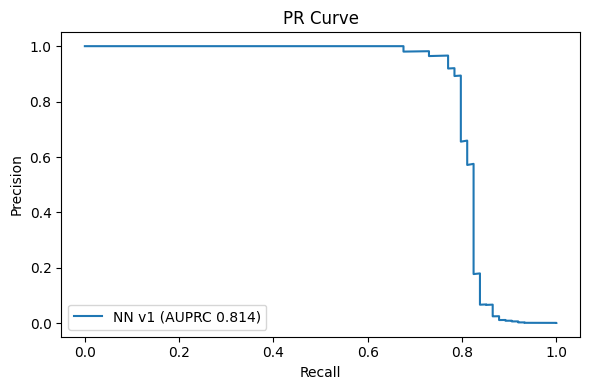

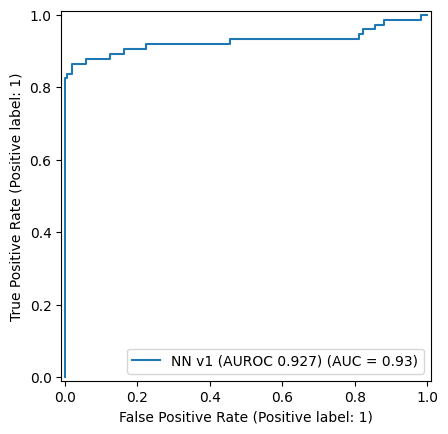

In [56]:
pr, rec, _ = precision_recall_curve(y_val, val_probs)
plt.figure(figsize=(6,4))
plt.plot(rec, pr, label=f'NN v1 (AUPRC {auprc:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curve'); plt.legend()
plt.tight_layout(); plt.show()

# ROC
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_val, val_probs, name=f'NN v1 (AUROC {auroc:.3f})')
plt.show()

In [57]:
os.makedirs('/content/models', exist_ok=True)
model.save('/content/models/nn_v1.h5')
json.dump({'auroc':auroc, 'auprc':auprc},
          open('/content/models/nn_v1_metrics.json','w'), indent=2)

### 🔍 Take-aways & next steps
* **Under-performance:** AUPRC 0.814 < 0.828 (XGB).  
  Likely causes: small network capacity, default LR, BCE loss not ideal for
  heavy class imbalance.
* **What could be concluded:**  
  * Dense nets need a bit more tuning than tree ensembles here.  
  * SMOTE may add noisy synthetic points—worth re-checking class-weights only.  
* **Plan for NN v2:**  
  1. Replace BCE with **Focal Loss** (γ = 2, α ≈ 0.25).  
  2. Grid-search width × depth & dropout with **Keras-Tuner**.  
  3. Try **Cosine LR decay** and **batch size 4096** for faster convergence.  
  4. Compare SMOTE vs. class-weights directly in mini-batches.
* Success criterion stays the same: **AUPRC > 0.828** on validation set.


In [59]:
SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

X_train = np.load('/content/data/processed/X_train.npy')
y_train = np.load('/content/data/processed/y_train.npy')
X_val   = np.load('/content/data/processed/X_val.npy')
y_val   = np.load('/content/data/processed/y_val.npy')

# ---- class weights instead of SMOTE ----
cls_w = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0:cls_w[0], 1:cls_w[1]}
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.5008642347502763), 1: np.float64(289.7732558139535)}


In [60]:
def focal_loss(alpha=0.25, gamma=2.0):
    def _focal(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1.0-eps)
        p_t = y_true * y_pred + (1-y_true)*(1-y_pred)
        alpha_t = y_true*alpha + (1-y_true)*(1-alpha)
        loss = -alpha_t * tf.pow(1-p_t, gamma) * tf.math.log(p_t)
        return tf.reduce_mean(loss)
    return _focal

In [65]:
def model_builder(hp: kt.HyperParameters):
    hp_units_1 = hp.Int('units_1', min_value=256, max_value=1024, step=256)
    hp_layers  = hp.Int('n_hidden', 2, 4)
    hp_drop    = hp.Float('dropout', 0.1, 0.4, step=0.1)
    hp_lr      = hp.Choice('lr', [1e-3, 5e-4, 1e-4])

    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = inputs
    units = hp_units_1
    for i in range(hp_layers):
        x = tf.keras.layers.Dense(units)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Dropout(hp_drop)(x)
        units = units // 2  # halve each layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
        loss=focal_loss(alpha=0.25, gamma=2.0),
        metrics=[tf.keras.metrics.AUC(name='auroc'),
                 tf.keras.metrics.AUC(name='auprc', curve='PR')]
    )
    return model

In [66]:
tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective('val_auprc', direction='max'),
    max_epochs=40,
    factor=3,
    directory='kt_logs',
    project_name='nn_v2')

stop = tf.keras.callbacks.EarlyStopping(monitor='val_auprc',
                                        patience=5, mode='max', restore_best_weights=True)

tuner.search(
    X_train, y_train,
    epochs=40,
    validation_data=(X_val, y_val),
    callbacks=[stop],
    class_weight=class_weights,
    verbose=2,
    batch_size=2048)


Trial 90 Complete [00h 00m 50s]
val_auprc: 0.8051919937133789

Best val_auprc So Far: 0.8347866535186768
Total elapsed time: 00h 36m 23s


In [67]:
best_model = tuner.get_best_models(1)[0]
val_probs = best_model.predict(X_val, batch_size=4096).ravel()
auroc  = roc_auc_score(y_val,  val_probs)
auprc  = average_precision_score(y_val, val_probs)
print(f"Best v2  AUROC {auroc:.4f}   AUPRC {auprc:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
Best v2  AUROC 0.9738   AUPRC 0.8350


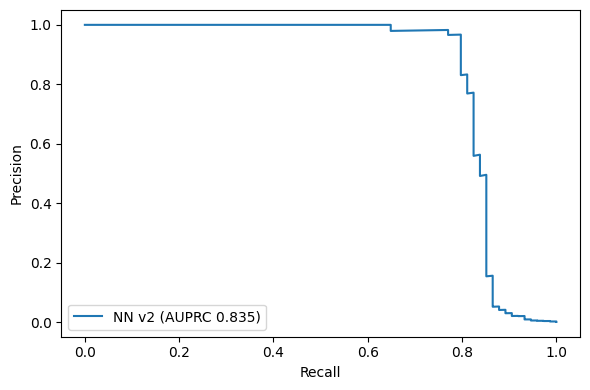

In [68]:
pr, rec, _ = precision_recall_curve(y_val, val_probs)
plt.figure(figsize=(6,4))
plt.plot(rec, pr, label=f'NN v2 (AUPRC {auprc:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(); plt.tight_layout(); plt.show()

best_model.save('/content/models/nn_v2.h5')
json.dump({'auroc':auroc, 'auprc':auprc},
          open('/content/models/nn_v2_metrics.json','w'), indent=2)

In [71]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        31,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 695,297 (2.65 MB)

 Trainable params: 691,713 (2.64 MB)

 Non-trainable params: 3,584 (14.00 KB)

# 8 · Test-set Evaluation & Threshold Tuning


In [76]:
# Load data and model

X_test = np.load('/content/data/processed/X_test.npy')
y_test = np.load('/content/data/processed/y_test.npy')

# Define the focal_loss function again for loading
def focal_loss(alpha=0.25, gamma=2.0):
    def _focal(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1.0-eps)
        p_t = y_true * y_pred + (1-y_true)*(1-y_pred)
        alpha_t = y_true*alpha + (1-y_true)*(1-alpha)
        loss = -alpha_t * tf.pow(1-p_t, gamma) * tf.math.log(p_t)
        return tf.reduce_mean(loss)
    # Return the inner _focal function
    return _focal

# Load the Keras model, providing the custom focal_loss function
nn = tf.keras.models.load_model('/content/models/nn_v2.h5',
                                custom_objects={'_focal': focal_loss()}) # Provide the actual function

xgb = joblib.load('/content/models/xgboost.pkl')

p_nn  = nn.predict(X_test, batch_size=4096).ravel()
p_xgb = xgb.predict_proba(X_test)[:,1]

print("NN v2  Test  AUROC", roc_auc_score(y_test,p_nn),
      "AUPRC", average_precision_score(y_test,p_nn))
print("XGBoost Test AUROC", roc_auc_score(y_test,p_xgb),
      "AUPRC", average_precision_score(y_test,p_xgb))

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step
NN v2  Test  AUROC 0.9635868986600556 AUPRC 0.8396145030379032
XGBoost Test AUROC 0.9699105056097177 AUPRC 0.8417024321285529


In [77]:
def best_threshold(probs, y_true, beta=1.):
    pr, rec, thr = precision_recall_curve(y_true, probs)
    f1 = (1+beta**2) * (pr*rec) / (beta**2*pr + rec + 1e-8)
    ix = f1.argmax()
    return thr[ix], pr[ix], rec[ix], f1[ix]

t_nn, prec_nn, rec_nn, f1_nn  = best_threshold(p_nn,  y_test)
t_xg, prec_xg, rec_xg, f1_xg  = best_threshold(p_xgb, y_test)
print(f"NN v2 threshold {t_nn:.2f}  P {prec_nn:.3f}  R {rec_nn:.3f}  F1 {f1_nn:.3f}")
print(f"XGB  threshold   {t_xg:.2f}  P {prec_xg:.3f}  R {rec_xg:.3f}  F1 {f1_xg:.3f}")

NN v2 threshold 0.47  P 0.953  R 0.824  F1 0.884
XGB  threshold   0.80  P 0.937  R 0.797  F1 0.861


In [78]:
def cost(probs, y_true, thr, c_fp=25, c_fn=600):
    y_pred = (probs>=thr).astype(int)
    fp = ((y_pred==1)&(y_true==0)).sum()
    fn = ((y_pred==0)&(y_true==1)).sum()
    return fp*c_fp + fn*c_fn

base_cost = cost(np.zeros_like(y_test), y_test, 1, 25, 600)   # detect nothing
cost_nn   = cost(p_nn,  y_test, t_nn)
cost_xgb  = cost(p_xgb, y_test, t_xg)
print(f"NN saved €{base_cost-cost_nn:,.0f}")
print(f"XGB saved €{base_cost-cost_xgb:,.0f}")

NN saved €36,525
XGB saved €35,300


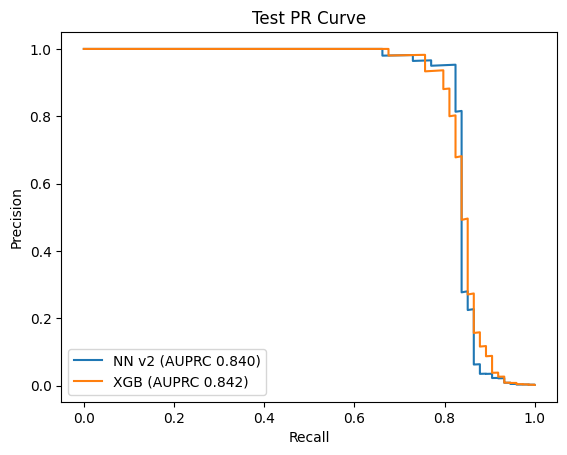

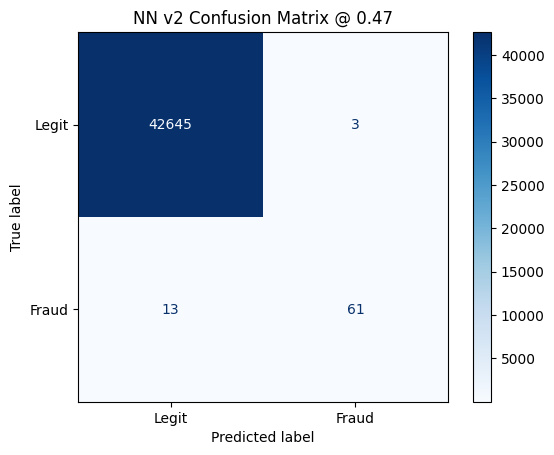

In [79]:
# PR curves
for label,probs in [("NN v2",p_nn), ("XGB",p_xgb)]:
    pr, rec, _ = precision_recall_curve(y_test, probs)
    plt.plot(rec, pr, label=f"{label} (AUPRC {average_precision_score(y_test,probs):.3f})")
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(); plt.title('Test PR Curve')
plt.show()

# Confusion matrix for NN v2 at chosen threshold
y_pred = (p_nn>=t_nn).astype(int)
cm = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Legit","Fraud"]).plot(cmap='Blues')
plt.title(f'NN v2 Confusion Matrix @ {t_nn:.2f}')
plt.show()